# Séance 2 - Calibration

On se propose dans ce notebook d'explorer une manière de recalibrer un modèle machine learning.
Pour le faire, nous allons travailler avec un dataset déséquilibré qui a pour but de prédire si une étoile est un pulsar ou non. On ne s'intéresse pas au travail de feature engineering ici.

In [25]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

df = pd.read_csv("pulsar_stars.csv")
df.head()

,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM,Skewness_DM,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Nous allons découper le dataset en trois parties:
* **Train** : entraîner le prédicteur
* **Validation** : recalibrer les prédictions
* **Test** : mesurer les performances du modèle

Nous en profitons également pour standardiser les données.

In [26]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["target"], axis=1)
y = df["target"]

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, stratify=y_train_valid)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
for vector, name in zip([y, y_train, y_valid, y_test], ["Initial", "Train", "Validation", "Test"]):
  print(f"{name}: {len(vector)} observations avec {vector.mean()*100:0.2f}% de la classe à prédire")

Initial: 17898 observations avec 9.16% de la classe à prédire
Train: 10067 observations avec 9.16% de la classe à prédire
Validation: 3356 observations avec 9.15% de la classe à prédire
Test: 4475 observations avec 9.16% de la classe à prédire


Nous remarquons que l'on travaille avec un dataset qui est déséquilibré de l'ordre de 9% de présence de la classe d'intérêt. Nous verrons comment cela peut impacter les prédictions.

## Entraînement du prédicteur

On décide de travailler avec une régression logistique et de mesurer les performances avec les métriques usuelles.

In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def print_performances(y_true, y_pred, metrics=[accuracy_score]):
  for metric in metrics:
    performance = metric(y_true=y_true, y_pred=y_pred)
    print(f"{metric.__name__}: {performance:0.4f}")

In [29]:
print_performances(y_test, y_pred, metrics=[accuracy_score, f1_score, precision_score, recall_score])

accuracy_score: 0.9779
f1_score: 0.8709
precision_score: 0.9356
recall_score: 0.8146


On obtient un très bon modèle, qui semble performant. Notons que l'accuracy ne donne pas une version très correcte de la performance par rapport au f1-score, ce qui était prévisible.

## Recalibration

Il existe de nombreuse manière de recalibrer les prédictions. On décide de le faire par la température, qui est probablement la manière la plus simple pour travailler.

On appelle **température** le scalaire $\tau > 0$ qui modifie les prédictions (avant normalisation) $(y_i)_{i\leqslant n}$ comme suit:

$$\forall i \leqslant n, \quad \tilde{y_i} = \frac{\displaystyle \exp\left(\frac{y_i}{\tau}\right)}{\displaystyle \sum_{j=1}^n \exp\left(\frac{y_j}{\tau}\right)}$$

Ainsi, si $\tau=1$ cela ne change pas les prédictions. Voyons quel impact ce paramètre a.
Nous allons avoir besoin à plusieurs reprise de deux fonctions:
* La fonction sigmoid : $\displaystyle \sigma(x) = \frac{1}{1+\exp(-x)}$
* Son inverse : $\displaystyle \sigma^{-1}(x) = \log\left(\frac{x}{1—x}\right)$
Pour ne pas avoir de problème numérique avec $\sigma^{-1}$, on va ajouter deux epsilons : $\displaystyle \tilde{\sigma^{-1}} = \ln\left(\frac{x}{1—x+\varepsilon}+\varepsilon\right)$. De cette manière, on évite de diviser par zéro, et on évite d'avoir une valeur négative dans le logarithme.

In [30]:
sigmoid = lambda x: 1 / (1+np.exp(-x))
def logit(x, epsilon=1e-8):
  return np.log(x / (1-x + epsilon) + epsilon)

def temperature(probabilities, tau=1):
  logits = logit(probabilities)
  return sigmoid(logits / tau)[:, 1]

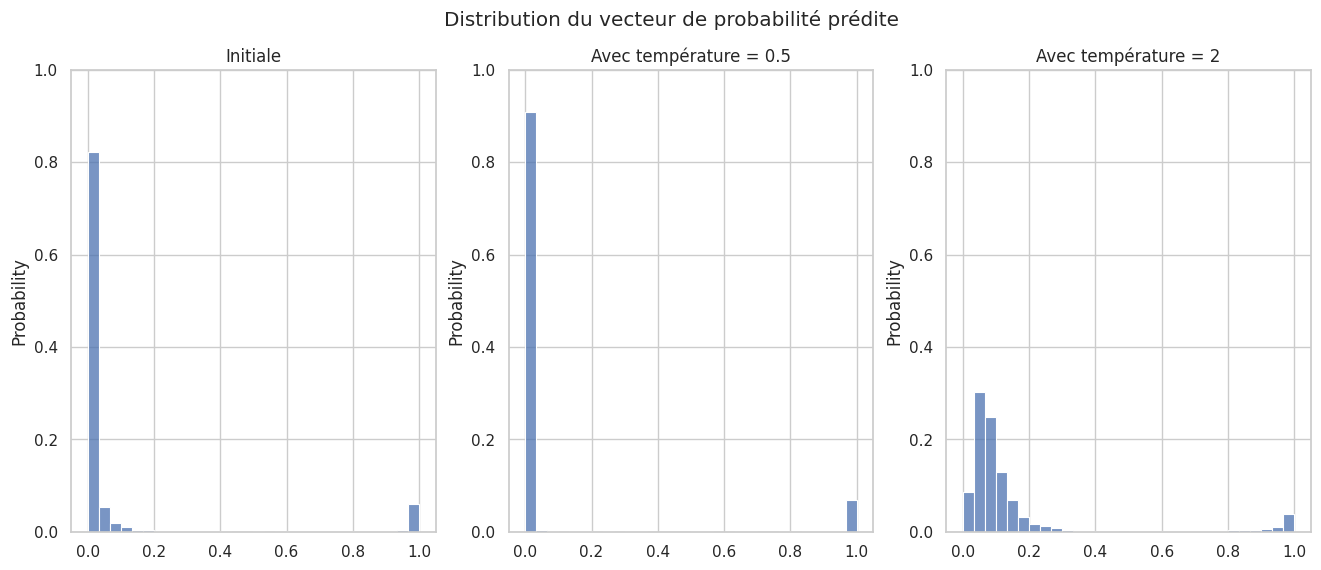

In [31]:
y_pred_proba = model.predict_proba(X_test)

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.histplot(y_pred_proba[:, 1], stat="probability", bins=30, binrange=(0, 1))
plt.title("Initiale")
plt.ylim(0, 1)

for index, tau in enumerate([0.5, 2]):
  plt.subplot(1, 3, index+2)
  probabilities = temperature(y_pred_proba, tau=tau)
  sns.histplot(probabilities, stat="probability", bins=30, binrange=(0, 1))
  plt.title(f"Avec température = {tau}")
  plt.ylim(0, 1)

plt.suptitle("Distribution du vecteur de probabilité prédite")
plt.show()

Remarquons pour commencer que les prédictions sont très concentrée aux extrêmes. Le modèle semble donc en majorité confiant, et de manière logique plutôt vers la prédiction de la classe majoritaire.

* Quand la température est faible, la tendance s'accentue aux extrêmes. Le modèle *gagne en confiance* dans ses prédictions.
* Quand la température est forte, la tendance s'amenuise pour avoir des prédictions moins manichéenne.

On se propose de trouver la meilleure valeur de $\tau$ pour calibrer au mieux les prédictions.

## Trouver la meilleure valeur de $\tau$

Pour le faire, nous allons utiliser les capacités d'optimisations de PyTorch. Puisque la *loss* qu'optimise la régression logistique est la *Cross-Entropy*, on va chercher à optimiser cette même loss sur les prédictions du jeu de validation.

Commençons par préparer les objets dont nous aurons besoins:
* Initialiser l'objet qui représentera la cross-entropie
* Calculer les probabilités prédites pour chaque observations du dataset de validation et les transformer en logits

In [32]:
import torch
from torch.nn import CrossEntropyLoss
loss = CrossEntropyLoss()
probabilities_validation = model.predict_proba(X_valid)
y_valid_tensor = torch.Tensor(np.array(y_valid)).type(torch.LongTensor)
logits = torch.Tensor(logit(probabilities_validation))

Nous aurons également besoin d'initialiser le paramètre $\tau$ que l'on va apprendre et l'objet qui représentera l'optimizer. On décide de travailler avec LBFGS.

In [33]:
tau_value = torch.nn.Parameter(torch.ones(1))
optimizer = torch.optim.LBFGS([tau_value], lr=0.01, max_iter=1000)

Calculons la valeur de la perte avant le post-processing :

In [34]:
scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
loss_value = loss(scaled, y_valid_tensor)
print(f"Tau={tau_value.item()}, Loss={loss_value.item():0.4f}")

Tau=1.0, Loss=0.1195


Mettons en place la boucle d'optimisation :

In [35]:
def eval():
  optimizer.zero_grad()
  scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
  loss_value = loss(scaled, y_valid_tensor)
  loss_value.backward()
  return loss_value

optimizer.step(eval)

scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
loss_value = loss(scaled, y_valid_tensor)
print(f"Tau={tau_value.item()}, Loss={loss_value.item():0.4f}")

Tau=2.053149938583374, Loss=0.0790


La fonction de perte est bien plus faible après ce processing en passant de 0.10 à 0.07. Avant de continuer, essayons de rendre plus simple cette optimisation en construisant une unique fonction.

In [36]:
def temperature_scaling(model, X, y, epsilon=1e-6):

  def eval():
    optimizer.zero_grad()
    scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
    loss_value = loss(scaled, y_tensor)
    loss_value.backward()
    return loss_value


  loss = CrossEntropyLoss()
  probabilities = model.predict_proba(X)
  y_tensor = torch.Tensor(np.array(y)).type(torch.LongTensor)
  logits = torch.Tensor(logit(probabilities))
  tau_value = torch.nn.Parameter(torch.ones(1))
  optimizer = torch.optim.LBFGS([tau_value], lr=0.01, max_iter=1000)
  optimizer.step(eval)

  return tau_value.item()

Qu'en est-il pour le reste des datasets ?

In [37]:
for X, y, name in zip([X_train, X_valid, X_test], [y_train, y_valid, y_test], ["Train", "Validation", "Test"]):
  y_score = model.predict_proba(X)
  y_true_tensor = torch.Tensor(np.array(y)).type(torch.LongTensor)
  logits = torch.Tensor(np.log(y_score / (1-y_score)))

  loss_before = loss(logits, y_true_tensor)
  scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
  loss_after = loss(scaled, y_true_tensor)
  print(f"{name} loss: initial = {loss_before.item():0.4f} vs after scaling = {loss_after.item():0.4f}")

Train loss: initial = 0.1022 vs after scaling = 0.0713
Validation loss: initial = 0.1195 vs after scaling = 0.0790
Test loss: initial = 0.1114 vs after scaling = 0.0748


La différence en valeur d'optimisation est bien conservée ! On a donc un gain certain d'optimisation de la loss avec cette méthode simple. Visualisons l'effet sur les métriques usuelles :

In [38]:
def plot_metrics(y_score, show=True):
  precision = []
  recall = []
  f1 = []
  thresholds = np.linspace(start=0.001, stop=0.99, num=50)

  for threshold in thresholds:
    y_pred = y_score[:, 1] > threshold
    precision.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1.append(f1_score(y_true=y_test, y_pred=y_pred))

  plt.axhline(y=np.max(f1), ls='--', alpha=0.8, color=sns.color_palette()[2])

  plt.plot(thresholds, precision, label="Precision")
  plt.plot(thresholds, recall, label="Recall")
  plt.plot(thresholds, f1, label="F1-Score", lw=2)

  plt.scatter(thresholds[np.argmax(f1)], precision[np.argmax(f1)])
  plt.scatter(thresholds[np.argmax(f1)], recall[np.argmax(f1)])
  plt.scatter(thresholds[np.argmax(f1)], max(f1))
  plt.ylim(0, 1)
  plt.legend()
  if show: plt.show()

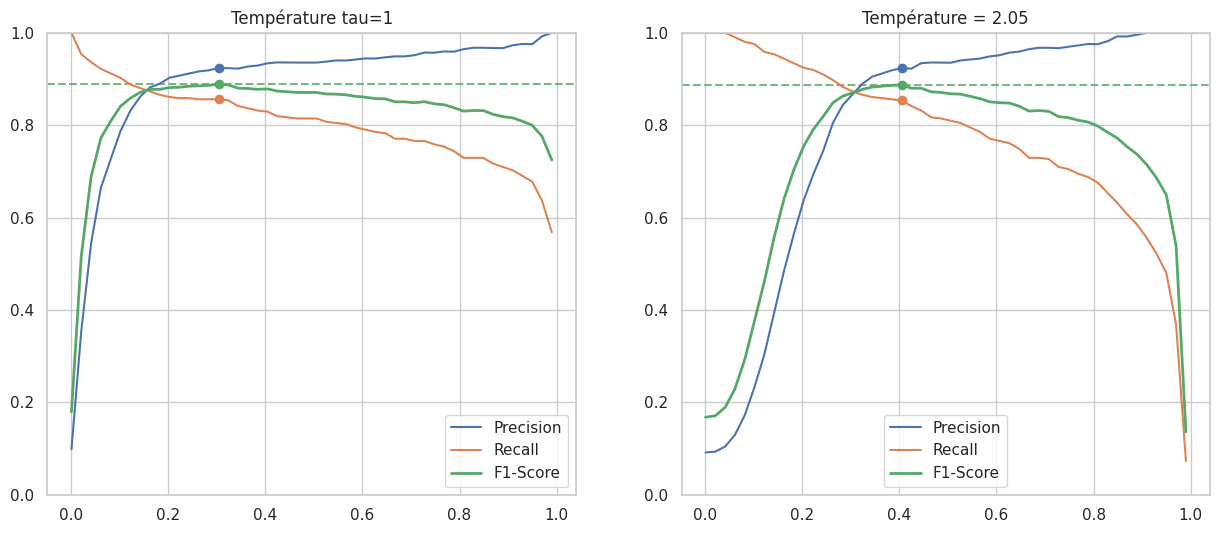

In [39]:
y_score = model.predict_proba(X_test)
logits = logit(y_score)
y_temperature = sigmoid(logits / tau_value.item())

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_metrics(y_score, show=False)
plt.title(f"Température tau=1")

plt.subplot(1, 2, 2)
plot_metrics(y_temperature, show=False)
plt.title(f"Température = {tau_value.item():0.2f}")

plt.show()

Les courbes deviennent plus brute, notamment au départ où la masse d'observations est concentrée. La meilleure performance reste identique, mais la calibration semble plus correcte à en juger par la coubre de précision.
Vérifions visuellement :

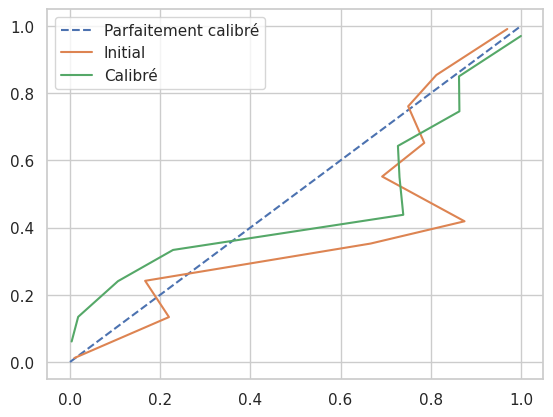

In [40]:
from sklearn.calibration import calibration_curve

plt.plot([0, 1], [0, 1], ls='--', label="Parfaitement calibré")
for y, name in zip([y_score, y_temperature], ["Initial", "Calibré"]):
  prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=y[:, 1], n_bins=10)
  plt.plot(prob_true, prob_pred, label=name)

plt.legend()
plt.show()

Aucun des deux prédicteurs n'est vraiment très bien calibré, mais on note une meilleure progression lorsque les prédictions ont été recalibré avec la méthode de la température.

Voyons ce que ça donne quand on utilise une random forest par exemple.

In [41]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier().fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)
print_performances(y_test, y_pred, metrics=[accuracy_score, f1_score, precision_score, recall_score])

accuracy_score: 0.9779
f1_score: 0.8709
precision_score: 0.9356
recall_score: 0.8146


Les valeurs de performances sont similaires, trouvons la meilleure température pour recalibrer les prédictions.

In [42]:
tau = temperature_scaling(model_RF, X_valid, y_valid)
print(f"{tau=}")

tau=2.8805809020996094


In [43]:
epsilon = 1e-8
for X, y, name in zip([X_train, X_valid, X_test], [y_train, y_valid, y_test], ["Train", "Validation", "Test"]):
  y_score = model_RF.predict_proba(X)
  y_true_tensor = torch.Tensor(np.array(y)).type(torch.LongTensor)
  logits = torch.Tensor(logit(y_score))

  loss_before = loss(logits, y_true_tensor)
  scaled = logits / tau_value.unsqueeze(1).expand(logits.size(0), logits.size(1))
  loss_after = loss(scaled, y_true_tensor)
  print(f"{name} loss: initial = {loss_before.item():0.4f} vs after scaling = {loss_after.item():0.4f}")

Train loss: initial = 0.0046 vs after scaling = 0.0144
Validation loss: initial = 0.2081 vs after scaling = 0.1220
Test loss: initial = 0.1794 vs after scaling = 0.1074


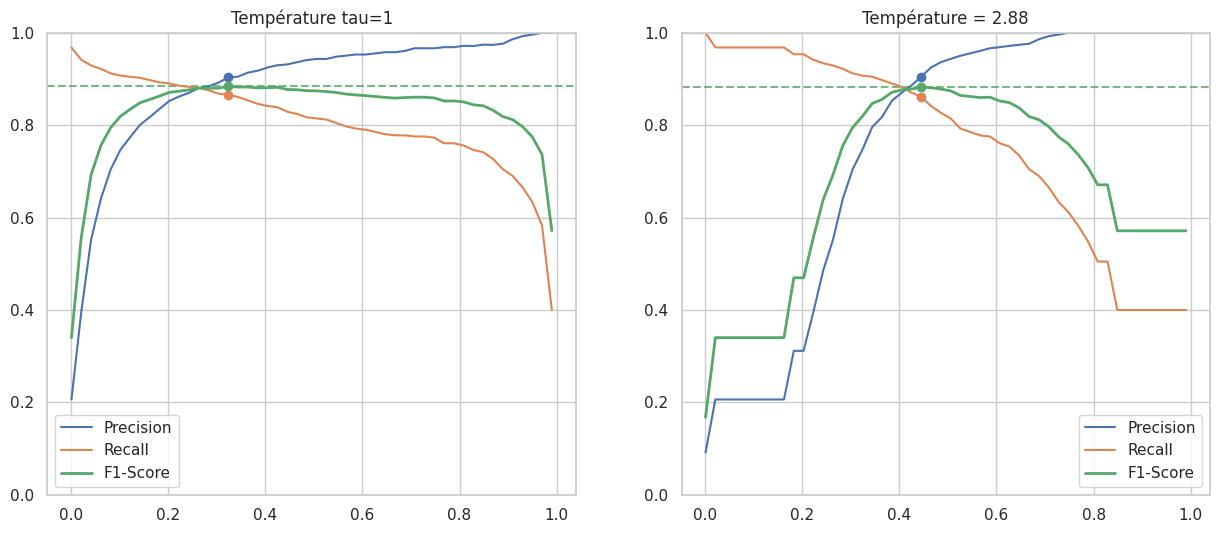

In [44]:
y_score = model_RF.predict_proba(X_test)
logits = logit(y_score)
y_temperature = sigmoid(logits / tau)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_metrics(y_score, show=False)
plt.title(f"Température tau=1")

plt.subplot(1, 2, 2)
plot_metrics(y_temperature, show=False)
plt.title(f"Température = {tau:0.2f}")

plt.show()

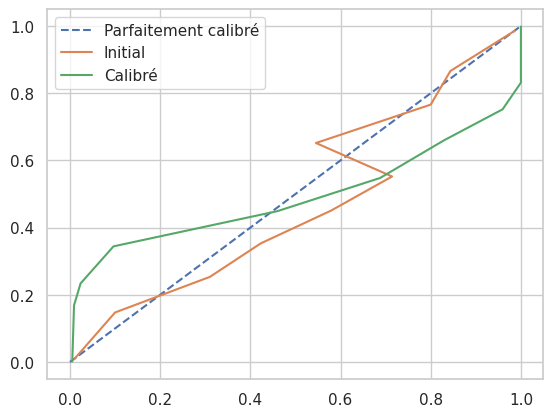

In [45]:
from sklearn.calibration import calibration_curve

plt.plot([0, 1], [0, 1], ls='--', label="Parfaitement calibré")
for y, name in zip([y_score, y_temperature], ["Initial", "Calibré"]):
  prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=y[:, 1], n_bins=10)
  plt.plot(prob_true, prob_pred, label=name)

plt.legend()
plt.show()